# Search YouTube videos using natural language

You can use this notebook to play with [OpenAI's CLIP](https://openai.com/blog/clip/) neural network for searching through YouTube videos using natural language.

## How it works

1. Download the YouTube video
2. Extract every N-th frame 
3. Encode all frames using using CLIP
4. Encode a natural language search query using CLIP
5. Find the images that best match the search query

## Select a YouTube video

Paste a link to a YouTube video or choose one of the examples. 

Choose a value for `N` which defines how many frames should be skipped. `N = 30` is usually about 1 frame every second.

In [ ]:
# Dashcam video of driving around San Francisco
video_url = "https://www.youtube.com/watch?v=PGMu_Z89Ao8"  

# How much frames to skip
N = 120

## Setup the environment

Install CLIP and install its dependencies.

In [ ]:
# pytube is used to download videos from YouTube
!pip install pytube

# Intall a newer version of plotly
!pip install plotly==4.14.3

# Install CLIP from the GitHub repo
!pip install git+https://github.com/openai/CLIP.git

# Install torch 1.7.1 with GPU support
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

## Download the video and process with CLIP

In this section the video is downloaded, every N-th frame is extracted and each frame is processed using CLIP.

Download the video locallyat 360p resoultion using `pytube`. A bigger resolution is not needed because CLIP scales down the images anyway.

In [ ]:
from pytube import YouTube

# Choose a video stream with resolution of 360p
streams = YouTube(video_url).streams.filter(adaptive=True, subtype="mp4", resolution="360p", only_video=True)

# Check if there is a valid stream
if len(streams) == 0:
  raise "No suitable stream found for this YouTube video!"

# Download the video as video.mp4
print("Downloading...")
streams[0].download(filename="video")
print("Download completed.")

Extract every `N-th` frame of the video.

In [ ]:
import cv2
from PIL import Image

# The frame images will be stored in video_frames
video_frames = []

# Open the video file
capture = cv2.VideoCapture('video.mp4')

current_frame = 0
while capture.isOpened():
  # Read the current frame
  ret, frame = capture.read()

  # Convert it to a PIL image (required for CLIP) and store it
  if ret == True:
    video_frames.append(Image.fromarray(frame[:, :, ::-1]))
  else:
    break

  # Skip N frames
  current_frame += N
  capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

# Print some statistics
print(f"Frames extracted: {len(video_frames)}")

Load the public CLIP model.

In [ ]:
import clip
import torch

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

Encode all frames using CLIP. The encoding is done in batches for a better efficiency.

In [ ]:
import math
import numpy as np
import torch

# You can try tuning the batch size for very large videos, but it should usually be OK
batch_size = 256
batches = math.ceil(len(video_frames) / batch_size)

# The encoded features will bs stored in video_features
video_features = torch.empty([0, 512], dtype=torch.float16).to(device)

# Process each batch
for i in range(batches):
  print(f"Processing batch {i+1}/{batches}")

  # Get the relevant frames
  batch_frames = video_frames[i*batch_size : (i+1)*batch_size]
  
  # Preprocess the images for the batch
  batch_preprocessed = torch.stack([preprocess(frame) for frame in batch_frames]).to(device)
  
  # Encode with CLIP and normalize
  with torch.no_grad():
    batch_features = model.encode_image(batch_preprocessed)
    batch_features /= batch_features.norm(dim=-1, keepdim=True)

  # Append the batch to the list containing all features
  video_features = torch.cat((video_features, batch_features))

# Print some stats
print(f"Features: {video_features.shape}")

## Define functions for searching the video

This section defines the functions used to search the video.

In [ ]:
import plotly.express as px

def search_video(search_query, display_heatmap=True, display_results_count=3):

  # Encode and normalize the search query using CLIP
  with torch.no_grad():
    text_features = model.encode_text(clip.tokenize(search_query).to(device))
    text_features /= text_features.norm(dim=-1, keepdim=True)

  # Compute the similarity between the search query and each frame using the Cosine similarity
  similarities = (100.0 * video_features @ text_features.T)
  values, best_photo_idx = similarities.topk(display_results_count, dim=0)

  # Display the heatmap
  if display_heatmap:
    print("Search query heatmap over the frames of the video:")
    fig = px.imshow(similarities.T.cpu().numpy(), height=50, aspect='auto', color_continuous_scale='viridis')
    fig.update_layout(coloraxis_showscale=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()
    print()

  # Display the top 3 frames
  for frame_id in best_photo_idx:
    display(video_frames[frame_id])
    print()

## Search queries

You can run the example search queries for some interesting results or you can try out your own.

On top of eah result you will also find a heatmap that shows how likely the search query is at all frames from the video.

### "A fire truck"

Search query heatmap over the frames of the video:


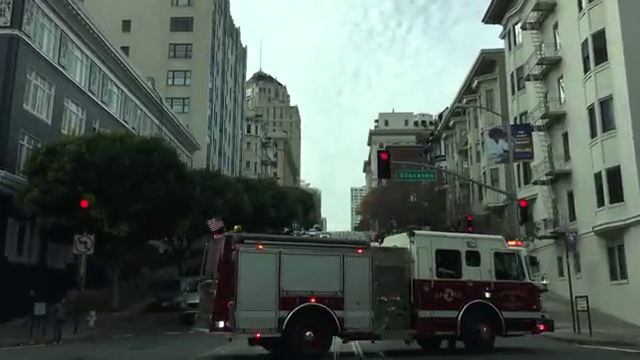

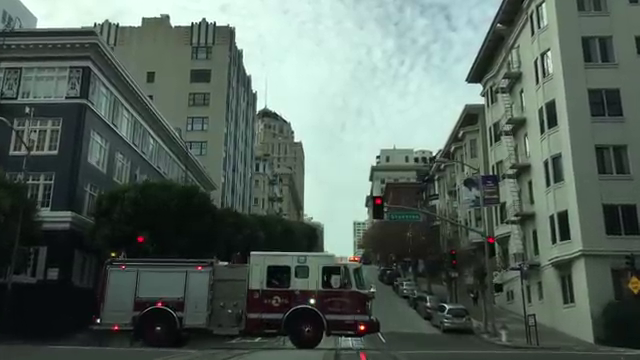

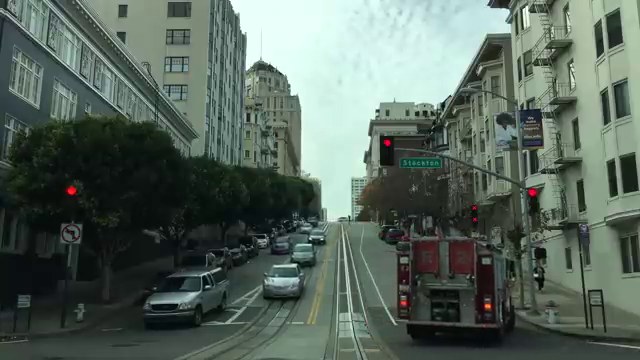

In [ ]:
search_video("a fire truck")

### "Road works"

Search query heatmap over the frames of the video:


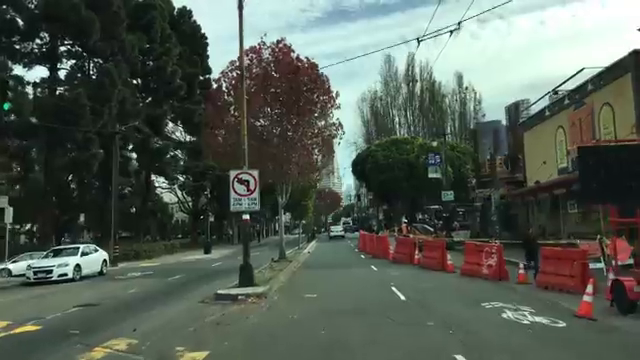

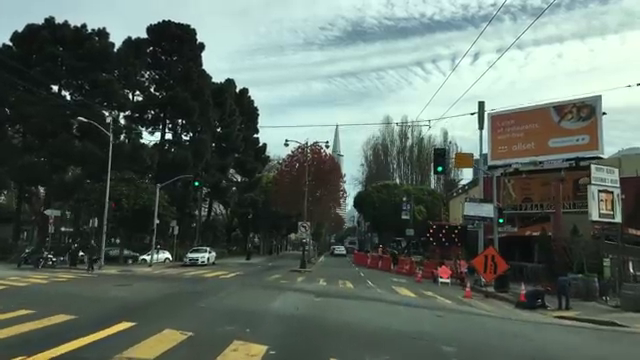

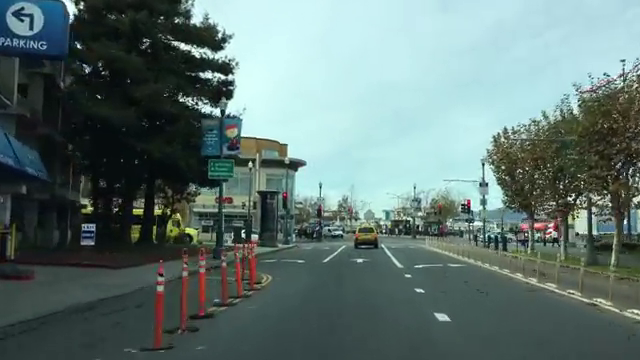

In [ ]:
search_video("road works")

### "People crossing the street"

Search query heatmap over the frames of the video:


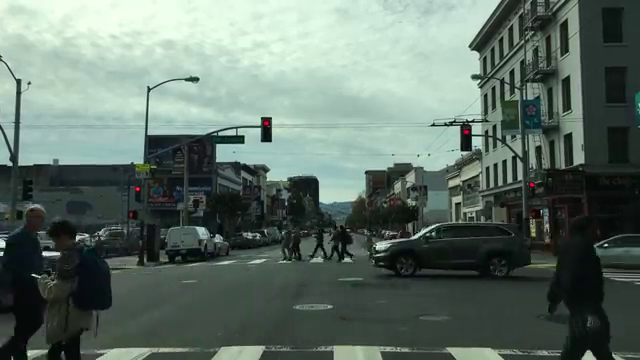

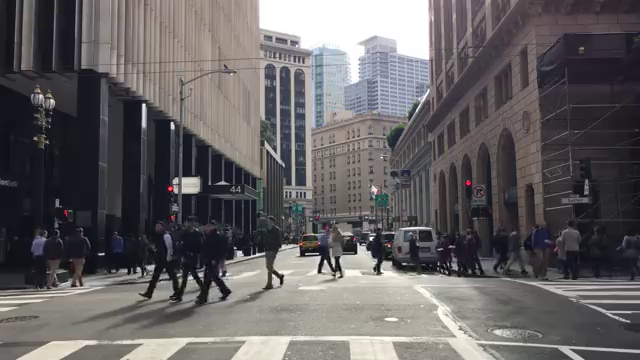

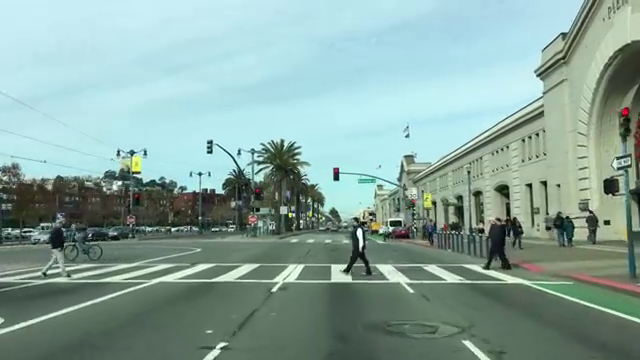

In [ ]:
search_video("people crossing the street")

### "The Embarcadero"

Search query heatmap over the frames of the video:


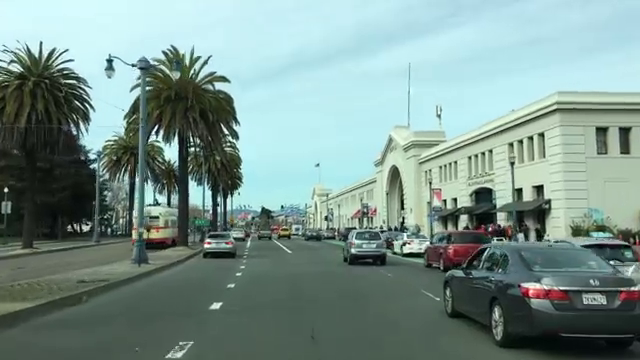

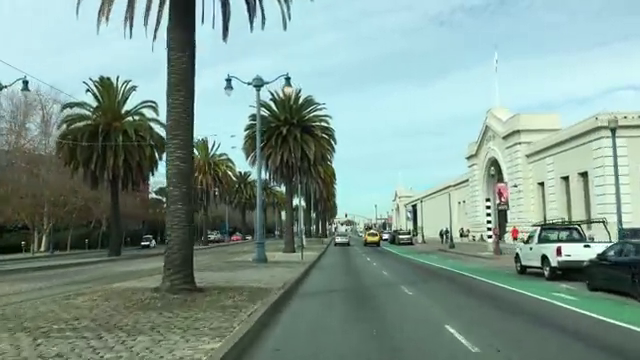

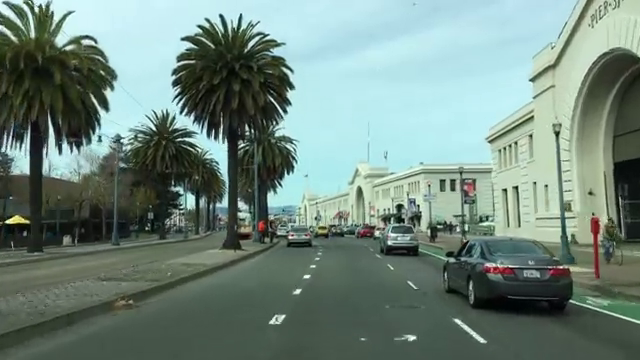

In [ ]:
search_video("the Embarcadero")

### "Waiting at the red light"

Search query heatmap over the frames of the video:


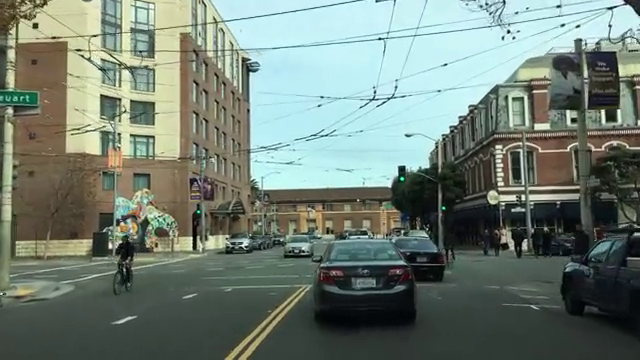

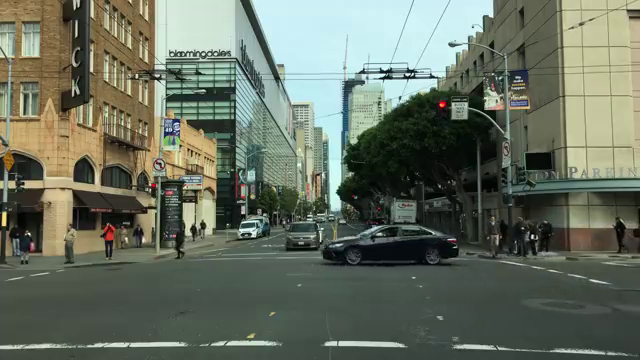

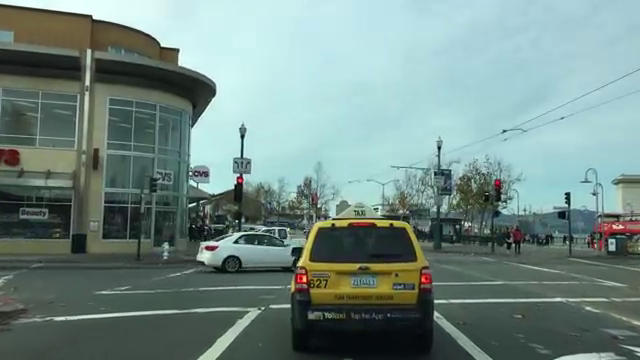

In [ ]:
search_video("waiting at the red light")

### "Green bike lane"

Search query heatmap over the frames of the video:


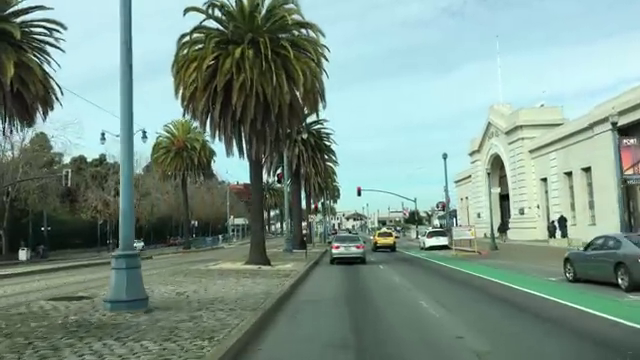

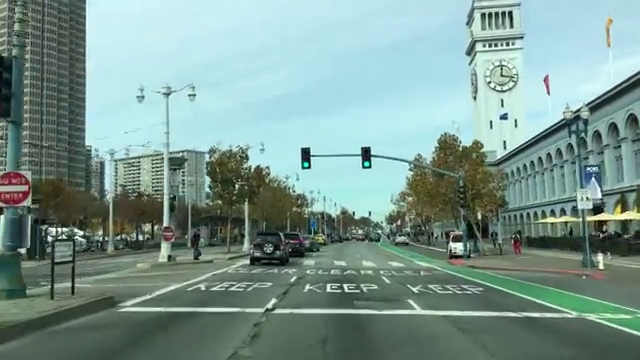

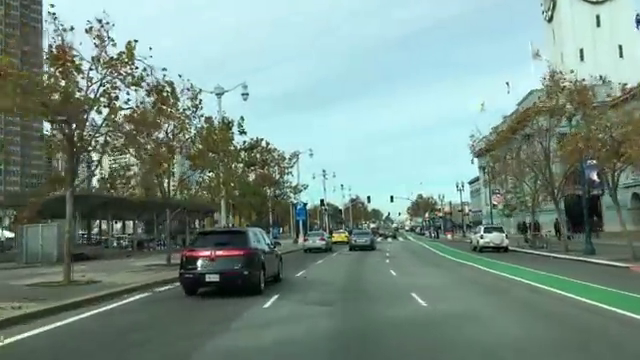

In [ ]:
search_video("green bike lane")

### "A street with tram tracks"

Search query heatmap over the frames of the video:


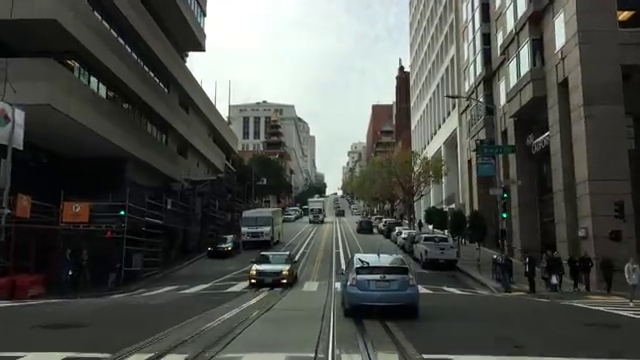

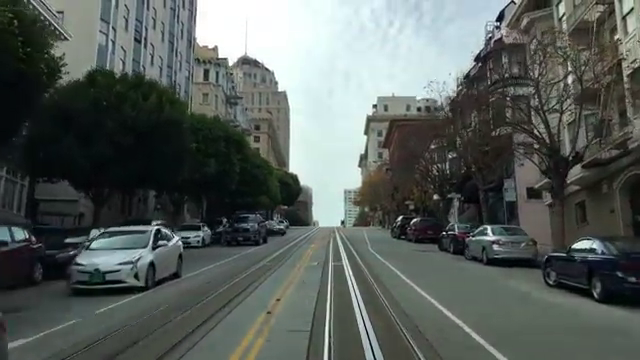

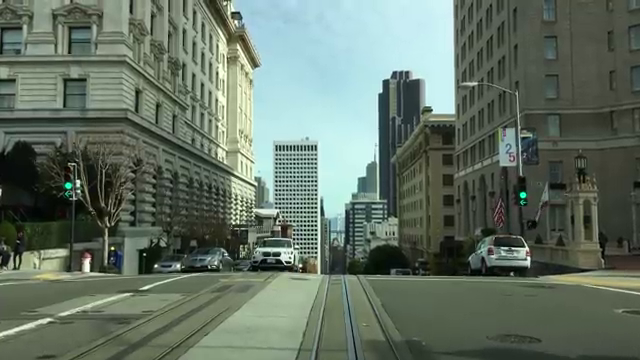

In [ ]:
search_video("a street with tram tracks")

### "The Transamerica Pyramid"

Search query heatmap over the frames of the video:


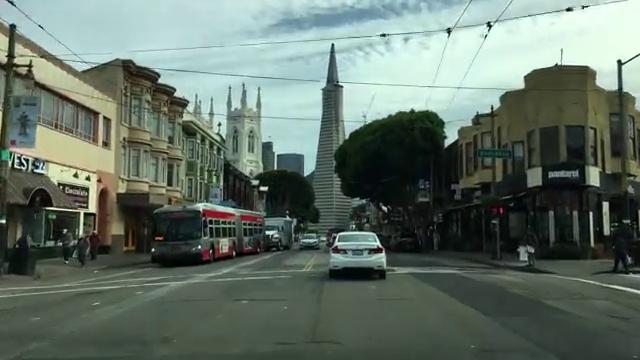

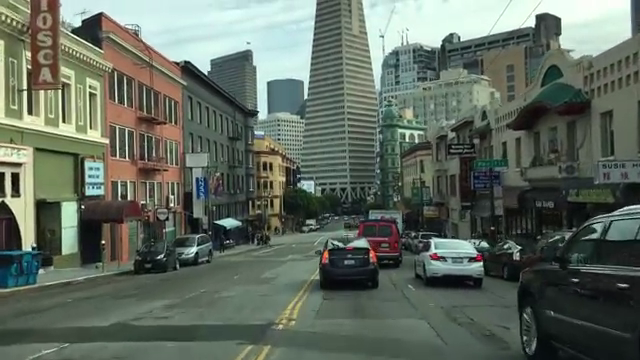

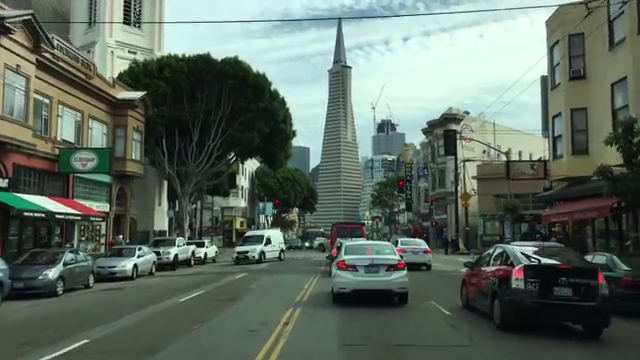

In [ ]:
search_video("the Transamerica Pyramid")